<a href="https://colab.research.google.com/github/rajagopalmotivate/try1/blob/master/DCGAN_Mnist_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

In [0]:
def load_data():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_data()

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=100, batch_size=32, save_interval=1)

-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.897386, acc.: 43.75%] [G loss: 0.766765]


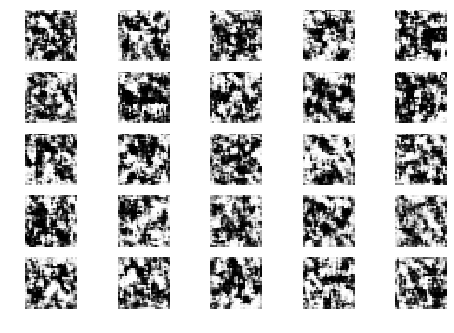

Epoch 0 Batch 1/1875 [D loss: 0.601496, acc.: 71.88%] [G loss: 0.631010]
Epoch 0 Batch 2/1875 [D loss: 0.718113, acc.: 59.38%] [G loss: 0.922297]
Epoch 0 Batch 3/1875 [D loss: 0.463987, acc.: 78.12%] [G loss: 0.966846]
Epoch 0 Batch 4/1875 [D loss: 0.538756, acc.: 65.62%] [G loss: 1.173902]
Epoch 0 Batch 5/1875 [D loss: 0.432308, acc.: 81.25%] [G loss: 1.041538]
Epoch 0 Batch 6/1875 [D loss: 0.388307, acc.: 90.62%] [G loss: 1.397034]
Epoch 0 Batch 7/1875 [D loss: 0.367625, acc.: 84.38%] [G loss: 1.293819]
Epoch 0 Batch 8/1875 [D loss: 0.344112, acc.: 93.75%] [G loss: 1.654612]
Epoch 0 Batch 9/1875 [D loss: 0.286051, acc.: 90.62%] [G loss: 1.384584]
Epoch 0 Batch 10/1875 [D loss: 0.382896, acc.: 84.38%] [G loss: 1.629426]
Epoch 0 Batch 11/1875 [D loss: 0.432951, acc.: 78.12%] [G loss: 1.554762]
Epoch 0 Batch 12/1875 [D loss: 0.228624, acc.: 93.75%] [G loss: 1.747231]
Epoch 0 Batch 13/1875 [D loss: 0.346373, acc.: 84.38%] [G loss: 1.776551]
Epoch 0 Batch 14/1875 [D loss: 0.270585, acc.: 

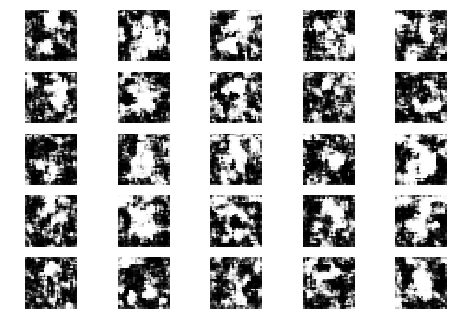

Epoch 0 Batch 51/1875 [D loss: 0.077010, acc.: 100.00%] [G loss: 3.763432]
Epoch 0 Batch 52/1875 [D loss: 0.060333, acc.: 100.00%] [G loss: 3.659831]
Epoch 0 Batch 53/1875 [D loss: 0.061141, acc.: 100.00%] [G loss: 4.216278]
Epoch 0 Batch 54/1875 [D loss: 0.028895, acc.: 100.00%] [G loss: 3.647384]
Epoch 0 Batch 55/1875 [D loss: 0.072466, acc.: 100.00%] [G loss: 3.388518]
Epoch 0 Batch 56/1875 [D loss: 0.085886, acc.: 96.88%] [G loss: 3.035370]
Epoch 0 Batch 57/1875 [D loss: 0.106654, acc.: 100.00%] [G loss: 3.719918]
Epoch 0 Batch 58/1875 [D loss: 0.072870, acc.: 100.00%] [G loss: 4.488157]
Epoch 0 Batch 59/1875 [D loss: 0.110406, acc.: 96.88%] [G loss: 3.338905]
Epoch 0 Batch 60/1875 [D loss: 0.044154, acc.: 100.00%] [G loss: 3.045511]
Epoch 0 Batch 61/1875 [D loss: 0.024584, acc.: 100.00%] [G loss: 2.893834]
Epoch 0 Batch 62/1875 [D loss: 0.088512, acc.: 100.00%] [G loss: 3.525994]
Epoch 0 Batch 63/1875 [D loss: 0.065217, acc.: 100.00%] [G loss: 3.424592]
Epoch 0 Batch 64/1875 [D lo

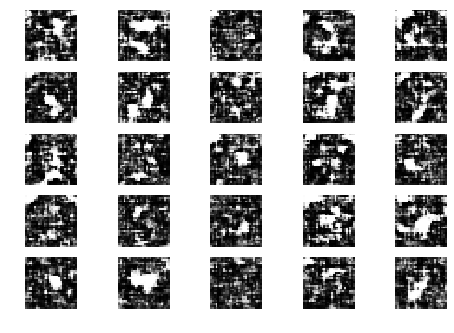

Epoch 0 Batch 101/1875 [D loss: 0.029736, acc.: 100.00%] [G loss: 4.363630]
Epoch 0 Batch 102/1875 [D loss: 0.275285, acc.: 90.62%] [G loss: 4.331826]
Epoch 0 Batch 103/1875 [D loss: 0.053766, acc.: 100.00%] [G loss: 4.467314]
Epoch 0 Batch 104/1875 [D loss: 0.154522, acc.: 93.75%] [G loss: 3.866333]
Epoch 0 Batch 105/1875 [D loss: 0.121436, acc.: 96.88%] [G loss: 4.631786]
Epoch 0 Batch 106/1875 [D loss: 0.244261, acc.: 90.62%] [G loss: 3.919052]
Epoch 0 Batch 107/1875 [D loss: 0.221399, acc.: 87.50%] [G loss: 4.919570]
Epoch 0 Batch 108/1875 [D loss: 0.335438, acc.: 87.50%] [G loss: 2.018235]
Epoch 0 Batch 109/1875 [D loss: 0.292656, acc.: 87.50%] [G loss: 4.177430]
Epoch 0 Batch 110/1875 [D loss: 0.116175, acc.: 100.00%] [G loss: 4.699919]
Epoch 0 Batch 111/1875 [D loss: 0.061792, acc.: 100.00%] [G loss: 4.066740]
Epoch 0 Batch 112/1875 [D loss: 0.369112, acc.: 78.12%] [G loss: 3.580043]
Epoch 0 Batch 113/1875 [D loss: 0.153410, acc.: 90.62%] [G loss: 4.332935]
Epoch 0 Batch 114/187

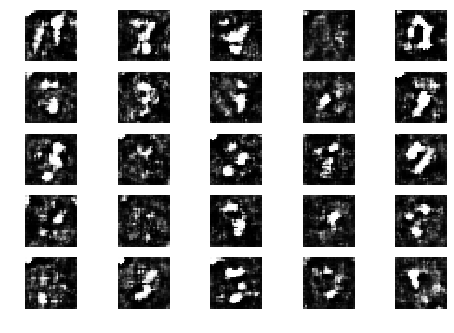

Epoch 0 Batch 151/1875 [D loss: 0.163557, acc.: 93.75%] [G loss: 3.432007]
Epoch 0 Batch 152/1875 [D loss: 0.385003, acc.: 84.38%] [G loss: 4.656651]
Epoch 0 Batch 153/1875 [D loss: 0.191254, acc.: 93.75%] [G loss: 3.899243]
Epoch 0 Batch 154/1875 [D loss: 0.598485, acc.: 68.75%] [G loss: 2.947596]
Epoch 0 Batch 155/1875 [D loss: 1.201987, acc.: 50.00%] [G loss: 3.876611]
Epoch 0 Batch 156/1875 [D loss: 0.480217, acc.: 84.38%] [G loss: 4.606959]
Epoch 0 Batch 157/1875 [D loss: 0.766424, acc.: 59.38%] [G loss: 2.406753]
Epoch 0 Batch 158/1875 [D loss: 0.443554, acc.: 84.38%] [G loss: 4.333804]
Epoch 0 Batch 159/1875 [D loss: 0.349976, acc.: 87.50%] [G loss: 2.771123]
Epoch 0 Batch 160/1875 [D loss: 0.551101, acc.: 68.75%] [G loss: 1.760149]
Epoch 0 Batch 161/1875 [D loss: 0.365011, acc.: 81.25%] [G loss: 3.346868]
Epoch 0 Batch 162/1875 [D loss: 1.096482, acc.: 46.88%] [G loss: 4.019651]
Epoch 0 Batch 163/1875 [D loss: 1.226979, acc.: 40.62%] [G loss: 1.890356]
Epoch 0 Batch 164/1875 [D

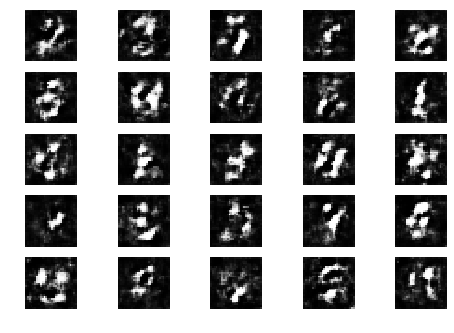

Epoch 0 Batch 201/1875 [D loss: 0.944068, acc.: 53.12%] [G loss: 2.001915]
Epoch 0 Batch 202/1875 [D loss: 0.970866, acc.: 40.62%] [G loss: 1.608327]
Epoch 0 Batch 203/1875 [D loss: 1.050820, acc.: 46.88%] [G loss: 1.617320]
Epoch 0 Batch 204/1875 [D loss: 0.824661, acc.: 50.00%] [G loss: 1.730641]
Epoch 0 Batch 205/1875 [D loss: 0.515233, acc.: 71.88%] [G loss: 2.181136]
Epoch 0 Batch 206/1875 [D loss: 0.856273, acc.: 56.25%] [G loss: 1.736191]
Epoch 0 Batch 207/1875 [D loss: 0.770893, acc.: 56.25%] [G loss: 1.994548]
Epoch 0 Batch 208/1875 [D loss: 0.964853, acc.: 40.62%] [G loss: 1.690219]
Epoch 0 Batch 209/1875 [D loss: 0.698860, acc.: 78.12%] [G loss: 2.024703]
Epoch 0 Batch 210/1875 [D loss: 0.934979, acc.: 50.00%] [G loss: 2.026198]
Epoch 0 Batch 211/1875 [D loss: 1.229526, acc.: 40.62%] [G loss: 1.311812]
Epoch 0 Batch 212/1875 [D loss: 0.916216, acc.: 56.25%] [G loss: 1.755507]
Epoch 0 Batch 213/1875 [D loss: 0.899435, acc.: 50.00%] [G loss: 1.507910]
Epoch 0 Batch 214/1875 [D

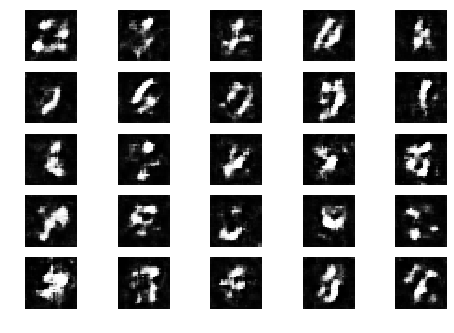

Epoch 0 Batch 251/1875 [D loss: 0.802325, acc.: 50.00%] [G loss: 1.377326]
Epoch 0 Batch 252/1875 [D loss: 0.921414, acc.: 50.00%] [G loss: 1.633158]
Epoch 0 Batch 253/1875 [D loss: 0.650206, acc.: 65.62%] [G loss: 1.316597]
Epoch 0 Batch 254/1875 [D loss: 0.553711, acc.: 71.88%] [G loss: 1.344925]
Epoch 0 Batch 255/1875 [D loss: 0.638776, acc.: 65.62%] [G loss: 1.291317]
Epoch 0 Batch 256/1875 [D loss: 0.577130, acc.: 75.00%] [G loss: 1.831588]
Epoch 0 Batch 257/1875 [D loss: 1.025853, acc.: 56.25%] [G loss: 1.289417]
Epoch 0 Batch 258/1875 [D loss: 1.088320, acc.: 37.50%] [G loss: 1.491921]
Epoch 0 Batch 259/1875 [D loss: 0.612023, acc.: 65.62%] [G loss: 1.616138]
Epoch 0 Batch 260/1875 [D loss: 0.713291, acc.: 62.50%] [G loss: 1.408643]
Epoch 0 Batch 261/1875 [D loss: 0.763311, acc.: 53.12%] [G loss: 1.984875]
Epoch 0 Batch 262/1875 [D loss: 0.873152, acc.: 50.00%] [G loss: 1.348832]
Epoch 0 Batch 263/1875 [D loss: 0.563484, acc.: 75.00%] [G loss: 1.330406]
Epoch 0 Batch 264/1875 [D

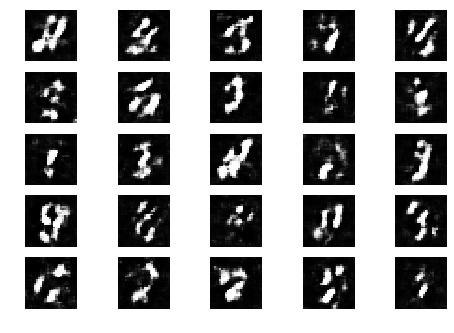

Epoch 0 Batch 301/1875 [D loss: 0.649824, acc.: 62.50%] [G loss: 1.652080]
Epoch 0 Batch 302/1875 [D loss: 0.805468, acc.: 62.50%] [G loss: 1.137913]
Epoch 0 Batch 303/1875 [D loss: 0.855655, acc.: 59.38%] [G loss: 1.333248]
Epoch 0 Batch 304/1875 [D loss: 1.026875, acc.: 43.75%] [G loss: 1.415641]
Epoch 0 Batch 305/1875 [D loss: 0.967230, acc.: 43.75%] [G loss: 1.903427]
Epoch 0 Batch 306/1875 [D loss: 0.740616, acc.: 56.25%] [G loss: 1.408343]
Epoch 0 Batch 307/1875 [D loss: 0.797713, acc.: 50.00%] [G loss: 1.590987]
Epoch 0 Batch 308/1875 [D loss: 0.753263, acc.: 56.25%] [G loss: 1.468356]
Epoch 0 Batch 309/1875 [D loss: 0.520083, acc.: 75.00%] [G loss: 1.724372]
Epoch 0 Batch 310/1875 [D loss: 0.876848, acc.: 40.62%] [G loss: 1.302669]
Epoch 0 Batch 311/1875 [D loss: 0.812398, acc.: 59.38%] [G loss: 1.356666]
Epoch 0 Batch 312/1875 [D loss: 0.571006, acc.: 65.62%] [G loss: 1.423444]
Epoch 0 Batch 313/1875 [D loss: 0.684181, acc.: 62.50%] [G loss: 1.535640]
Epoch 0 Batch 314/1875 [D

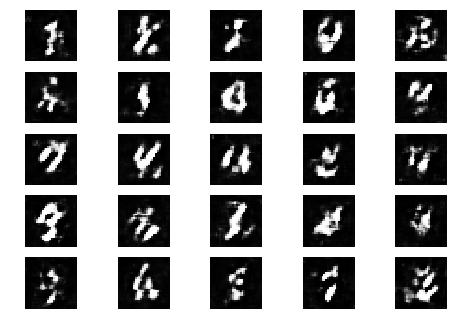

Epoch 0 Batch 351/1875 [D loss: 0.585298, acc.: 71.88%] [G loss: 1.477402]
Epoch 0 Batch 352/1875 [D loss: 0.808869, acc.: 56.25%] [G loss: 1.385565]
Epoch 0 Batch 353/1875 [D loss: 1.043949, acc.: 40.62%] [G loss: 1.143023]
Epoch 0 Batch 354/1875 [D loss: 0.745654, acc.: 59.38%] [G loss: 1.341724]
Epoch 0 Batch 355/1875 [D loss: 0.847583, acc.: 46.88%] [G loss: 1.280000]
Epoch 0 Batch 356/1875 [D loss: 0.896817, acc.: 40.62%] [G loss: 1.333099]
Epoch 0 Batch 357/1875 [D loss: 0.586214, acc.: 71.88%] [G loss: 1.583109]
Epoch 0 Batch 358/1875 [D loss: 0.748965, acc.: 62.50%] [G loss: 1.395095]
Epoch 0 Batch 359/1875 [D loss: 0.574395, acc.: 65.62%] [G loss: 1.323467]
Epoch 0 Batch 360/1875 [D loss: 0.814143, acc.: 59.38%] [G loss: 1.142432]
Epoch 0 Batch 361/1875 [D loss: 0.515911, acc.: 65.62%] [G loss: 1.317202]
Epoch 0 Batch 362/1875 [D loss: 0.949566, acc.: 37.50%] [G loss: 1.032144]
Epoch 0 Batch 363/1875 [D loss: 0.886331, acc.: 53.12%] [G loss: 1.760736]
Epoch 0 Batch 364/1875 [D

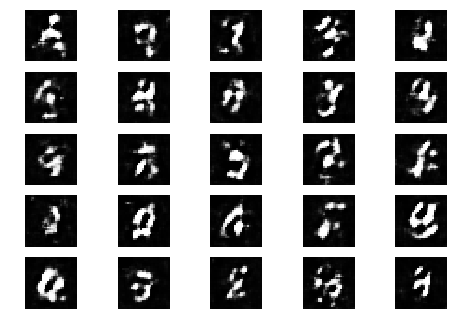

Epoch 0 Batch 401/1875 [D loss: 0.670171, acc.: 65.62%] [G loss: 1.345857]
Epoch 0 Batch 402/1875 [D loss: 0.839307, acc.: 56.25%] [G loss: 1.066056]
Epoch 0 Batch 403/1875 [D loss: 1.029279, acc.: 50.00%] [G loss: 1.438979]
Epoch 0 Batch 404/1875 [D loss: 0.887124, acc.: 50.00%] [G loss: 1.497270]
Epoch 0 Batch 405/1875 [D loss: 0.725722, acc.: 65.62%] [G loss: 1.303282]
Epoch 0 Batch 406/1875 [D loss: 0.754014, acc.: 50.00%] [G loss: 1.060368]
Epoch 0 Batch 407/1875 [D loss: 0.789756, acc.: 56.25%] [G loss: 1.225430]
Epoch 0 Batch 408/1875 [D loss: 0.690135, acc.: 56.25%] [G loss: 1.144199]
Epoch 0 Batch 409/1875 [D loss: 0.860460, acc.: 46.88%] [G loss: 1.205285]
Epoch 0 Batch 410/1875 [D loss: 0.680870, acc.: 56.25%] [G loss: 1.354100]
Epoch 0 Batch 411/1875 [D loss: 0.634120, acc.: 59.38%] [G loss: 1.133710]
Epoch 0 Batch 412/1875 [D loss: 0.770673, acc.: 53.12%] [G loss: 1.451268]
Epoch 0 Batch 413/1875 [D loss: 0.870556, acc.: 40.62%] [G loss: 1.286706]
Epoch 0 Batch 414/1875 [D

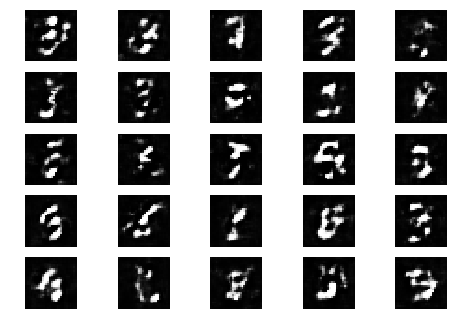

Epoch 0 Batch 451/1875 [D loss: 0.633788, acc.: 71.88%] [G loss: 1.323070]
Epoch 0 Batch 452/1875 [D loss: 0.949644, acc.: 53.12%] [G loss: 1.499841]
Epoch 0 Batch 453/1875 [D loss: 0.801691, acc.: 40.62%] [G loss: 1.275972]
Epoch 0 Batch 454/1875 [D loss: 0.543806, acc.: 75.00%] [G loss: 1.216536]
Epoch 0 Batch 455/1875 [D loss: 0.768730, acc.: 53.12%] [G loss: 1.091319]
Epoch 0 Batch 456/1875 [D loss: 0.514532, acc.: 68.75%] [G loss: 1.330992]
Epoch 0 Batch 457/1875 [D loss: 0.701036, acc.: 56.25%] [G loss: 1.138717]
Epoch 0 Batch 458/1875 [D loss: 0.614479, acc.: 59.38%] [G loss: 1.219703]
Epoch 0 Batch 459/1875 [D loss: 0.843266, acc.: 43.75%] [G loss: 1.160288]
Epoch 0 Batch 460/1875 [D loss: 0.762109, acc.: 65.62%] [G loss: 1.274690]
Epoch 0 Batch 461/1875 [D loss: 0.721026, acc.: 56.25%] [G loss: 1.287784]
Epoch 0 Batch 462/1875 [D loss: 0.809143, acc.: 53.12%] [G loss: 1.251527]
Epoch 0 Batch 463/1875 [D loss: 0.745754, acc.: 56.25%] [G loss: 1.097025]
Epoch 0 Batch 464/1875 [D

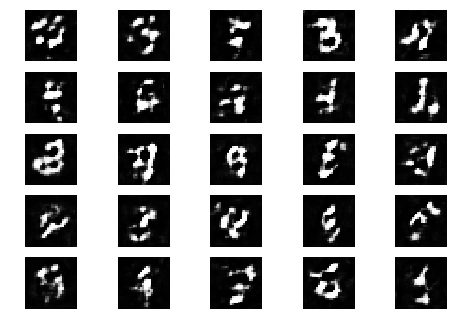

Epoch 0 Batch 501/1875 [D loss: 0.864285, acc.: 56.25%] [G loss: 1.233889]
Epoch 0 Batch 502/1875 [D loss: 0.602565, acc.: 62.50%] [G loss: 1.011048]
Epoch 0 Batch 503/1875 [D loss: 0.649842, acc.: 75.00%] [G loss: 1.209161]
Epoch 0 Batch 504/1875 [D loss: 0.646104, acc.: 62.50%] [G loss: 1.102395]
Epoch 0 Batch 505/1875 [D loss: 0.760871, acc.: 62.50%] [G loss: 1.010563]
Epoch 0 Batch 506/1875 [D loss: 0.552144, acc.: 75.00%] [G loss: 1.324133]
Epoch 0 Batch 507/1875 [D loss: 0.634855, acc.: 68.75%] [G loss: 1.465910]
Epoch 0 Batch 508/1875 [D loss: 0.777055, acc.: 40.62%] [G loss: 1.277159]
Epoch 0 Batch 509/1875 [D loss: 0.817718, acc.: 53.12%] [G loss: 1.236305]
Epoch 0 Batch 510/1875 [D loss: 0.672761, acc.: 68.75%] [G loss: 1.317576]
Epoch 0 Batch 511/1875 [D loss: 0.810502, acc.: 43.75%] [G loss: 1.480994]
Epoch 0 Batch 512/1875 [D loss: 0.662510, acc.: 56.25%] [G loss: 1.431909]
Epoch 0 Batch 513/1875 [D loss: 0.574953, acc.: 75.00%] [G loss: 1.277177]
Epoch 0 Batch 514/1875 [D

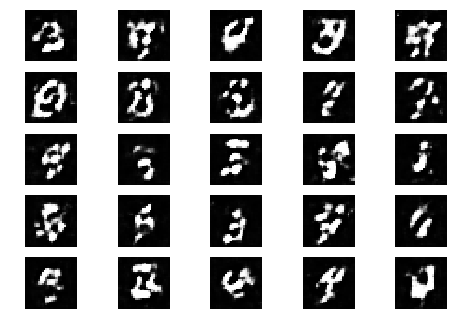

Epoch 0 Batch 551/1875 [D loss: 0.465728, acc.: 81.25%] [G loss: 1.148583]
Epoch 0 Batch 552/1875 [D loss: 0.543132, acc.: 71.88%] [G loss: 1.114698]
Epoch 0 Batch 553/1875 [D loss: 0.802294, acc.: 50.00%] [G loss: 1.297822]
Epoch 0 Batch 554/1875 [D loss: 0.764736, acc.: 53.12%] [G loss: 0.880230]
Epoch 0 Batch 555/1875 [D loss: 0.542980, acc.: 71.88%] [G loss: 1.121477]
Epoch 0 Batch 556/1875 [D loss: 0.841728, acc.: 53.12%] [G loss: 1.179947]
Epoch 0 Batch 557/1875 [D loss: 0.618776, acc.: 71.88%] [G loss: 1.508220]
Epoch 0 Batch 558/1875 [D loss: 0.633412, acc.: 53.12%] [G loss: 1.409514]
Epoch 0 Batch 559/1875 [D loss: 0.851696, acc.: 59.38%] [G loss: 0.959802]
Epoch 0 Batch 560/1875 [D loss: 0.602910, acc.: 65.62%] [G loss: 1.095715]
Epoch 0 Batch 561/1875 [D loss: 0.553908, acc.: 68.75%] [G loss: 1.318657]
Epoch 0 Batch 562/1875 [D loss: 0.698471, acc.: 46.88%] [G loss: 1.159583]
Epoch 0 Batch 563/1875 [D loss: 0.828835, acc.: 46.88%] [G loss: 1.224313]
Epoch 0 Batch 564/1875 [D

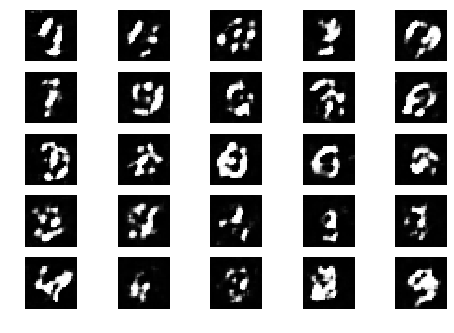

Epoch 0 Batch 601/1875 [D loss: 0.591584, acc.: 68.75%] [G loss: 1.285945]
Epoch 0 Batch 602/1875 [D loss: 0.604765, acc.: 59.38%] [G loss: 1.126270]
Epoch 0 Batch 603/1875 [D loss: 0.576798, acc.: 65.62%] [G loss: 1.084802]
Epoch 0 Batch 604/1875 [D loss: 0.631666, acc.: 65.62%] [G loss: 1.074827]
Epoch 0 Batch 605/1875 [D loss: 0.781407, acc.: 59.38%] [G loss: 1.047484]
Epoch 0 Batch 606/1875 [D loss: 0.554773, acc.: 71.88%] [G loss: 1.131519]
Epoch 0 Batch 607/1875 [D loss: 0.719823, acc.: 50.00%] [G loss: 1.044333]
Epoch 0 Batch 608/1875 [D loss: 0.860440, acc.: 40.62%] [G loss: 0.935086]
Epoch 0 Batch 609/1875 [D loss: 0.527595, acc.: 81.25%] [G loss: 1.386318]
Epoch 0 Batch 610/1875 [D loss: 0.461538, acc.: 75.00%] [G loss: 1.170758]
Epoch 0 Batch 611/1875 [D loss: 0.806686, acc.: 46.88%] [G loss: 0.934048]
Epoch 0 Batch 612/1875 [D loss: 0.562439, acc.: 71.88%] [G loss: 1.238628]
Epoch 0 Batch 613/1875 [D loss: 0.526665, acc.: 71.88%] [G loss: 1.294023]
Epoch 0 Batch 614/1875 [D

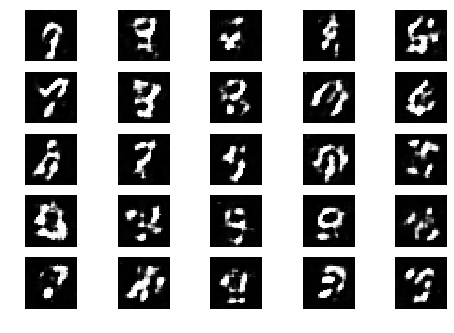

Epoch 0 Batch 651/1875 [D loss: 0.746109, acc.: 46.88%] [G loss: 1.120112]
Epoch 0 Batch 652/1875 [D loss: 0.636687, acc.: 68.75%] [G loss: 1.216005]
Epoch 0 Batch 653/1875 [D loss: 0.616083, acc.: 68.75%] [G loss: 1.330648]
Epoch 0 Batch 654/1875 [D loss: 0.621737, acc.: 62.50%] [G loss: 1.421078]
Epoch 0 Batch 655/1875 [D loss: 0.860648, acc.: 53.12%] [G loss: 1.079462]
Epoch 0 Batch 656/1875 [D loss: 0.641658, acc.: 62.50%] [G loss: 1.029002]
Epoch 0 Batch 657/1875 [D loss: 0.802433, acc.: 56.25%] [G loss: 1.444072]
Epoch 0 Batch 658/1875 [D loss: 0.527247, acc.: 78.12%] [G loss: 1.089330]
Epoch 0 Batch 659/1875 [D loss: 0.712536, acc.: 56.25%] [G loss: 1.156894]
Epoch 0 Batch 660/1875 [D loss: 0.835435, acc.: 50.00%] [G loss: 1.161491]
Epoch 0 Batch 661/1875 [D loss: 0.633588, acc.: 68.75%] [G loss: 0.887628]
Epoch 0 Batch 662/1875 [D loss: 0.814181, acc.: 46.88%] [G loss: 1.033111]
Epoch 0 Batch 663/1875 [D loss: 0.428323, acc.: 87.50%] [G loss: 1.110284]
Epoch 0 Batch 664/1875 [D

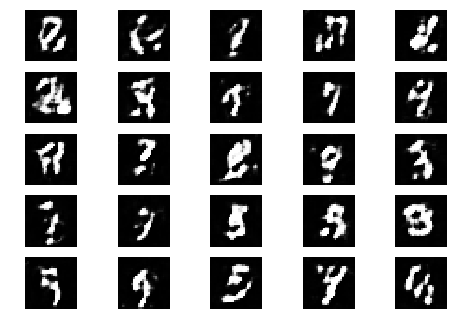

Epoch 0 Batch 701/1875 [D loss: 0.814746, acc.: 50.00%] [G loss: 1.107272]
Epoch 0 Batch 702/1875 [D loss: 0.580495, acc.: 78.12%] [G loss: 1.025523]
Epoch 0 Batch 703/1875 [D loss: 0.693084, acc.: 65.62%] [G loss: 1.167452]
Epoch 0 Batch 704/1875 [D loss: 0.801825, acc.: 50.00%] [G loss: 1.322885]
Epoch 0 Batch 705/1875 [D loss: 0.587447, acc.: 65.62%] [G loss: 1.095922]
Epoch 0 Batch 706/1875 [D loss: 0.585152, acc.: 62.50%] [G loss: 0.994214]
Epoch 0 Batch 707/1875 [D loss: 0.621443, acc.: 50.00%] [G loss: 1.271566]
Epoch 0 Batch 708/1875 [D loss: 0.735840, acc.: 59.38%] [G loss: 1.380113]
Epoch 0 Batch 709/1875 [D loss: 0.631606, acc.: 59.38%] [G loss: 1.046016]
Epoch 0 Batch 710/1875 [D loss: 0.485569, acc.: 78.12%] [G loss: 1.274308]
Epoch 0 Batch 711/1875 [D loss: 0.693037, acc.: 62.50%] [G loss: 1.064502]
Epoch 0 Batch 712/1875 [D loss: 0.657780, acc.: 56.25%] [G loss: 1.205130]
Epoch 0 Batch 713/1875 [D loss: 0.633703, acc.: 65.62%] [G loss: 0.892235]
Epoch 0 Batch 714/1875 [D

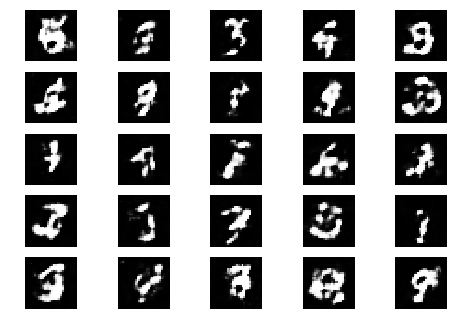

Epoch 0 Batch 751/1875 [D loss: 0.812059, acc.: 46.88%] [G loss: 1.180162]
Epoch 0 Batch 752/1875 [D loss: 0.647287, acc.: 71.88%] [G loss: 1.511801]
Epoch 0 Batch 753/1875 [D loss: 0.648251, acc.: 59.38%] [G loss: 1.127621]
Epoch 0 Batch 754/1875 [D loss: 0.806247, acc.: 46.88%] [G loss: 0.841641]
Epoch 0 Batch 755/1875 [D loss: 0.634246, acc.: 68.75%] [G loss: 1.353279]
Epoch 0 Batch 756/1875 [D loss: 0.668790, acc.: 56.25%] [G loss: 1.190861]
Epoch 0 Batch 757/1875 [D loss: 0.683482, acc.: 62.50%] [G loss: 0.916870]
Epoch 0 Batch 758/1875 [D loss: 0.592386, acc.: 68.75%] [G loss: 0.964111]
Epoch 0 Batch 759/1875 [D loss: 0.667253, acc.: 65.62%] [G loss: 1.135180]
Epoch 0 Batch 760/1875 [D loss: 0.730949, acc.: 46.88%] [G loss: 1.421886]
Epoch 0 Batch 761/1875 [D loss: 0.646599, acc.: 56.25%] [G loss: 1.010433]
Epoch 0 Batch 762/1875 [D loss: 0.705596, acc.: 56.25%] [G loss: 1.490113]
Epoch 0 Batch 763/1875 [D loss: 0.620566, acc.: 71.88%] [G loss: 1.255716]
Epoch 0 Batch 764/1875 [D

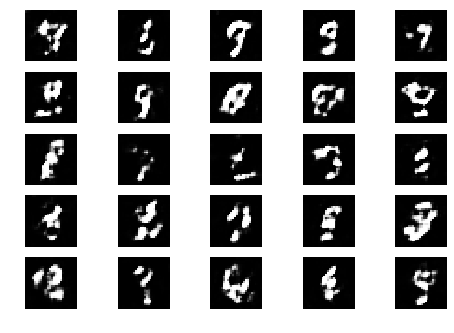

Epoch 0 Batch 801/1875 [D loss: 0.727634, acc.: 62.50%] [G loss: 1.388442]
Epoch 0 Batch 802/1875 [D loss: 0.565626, acc.: 65.62%] [G loss: 1.639093]
Epoch 0 Batch 803/1875 [D loss: 0.743009, acc.: 53.12%] [G loss: 1.270873]
Epoch 0 Batch 804/1875 [D loss: 0.744641, acc.: 46.88%] [G loss: 0.942963]
Epoch 0 Batch 805/1875 [D loss: 0.608776, acc.: 68.75%] [G loss: 1.251365]
Epoch 0 Batch 806/1875 [D loss: 0.798711, acc.: 53.12%] [G loss: 1.325203]
Epoch 0 Batch 807/1875 [D loss: 0.796577, acc.: 46.88%] [G loss: 1.211724]
Epoch 0 Batch 808/1875 [D loss: 0.575872, acc.: 68.75%] [G loss: 1.048370]
Epoch 0 Batch 809/1875 [D loss: 0.617262, acc.: 68.75%] [G loss: 1.156165]
Epoch 0 Batch 810/1875 [D loss: 0.574989, acc.: 68.75%] [G loss: 1.120784]
Epoch 0 Batch 811/1875 [D loss: 0.581658, acc.: 71.88%] [G loss: 1.075904]
Epoch 0 Batch 812/1875 [D loss: 0.862955, acc.: 46.88%] [G loss: 1.255988]
Epoch 0 Batch 813/1875 [D loss: 0.749670, acc.: 50.00%] [G loss: 1.358617]
Epoch 0 Batch 814/1875 [D

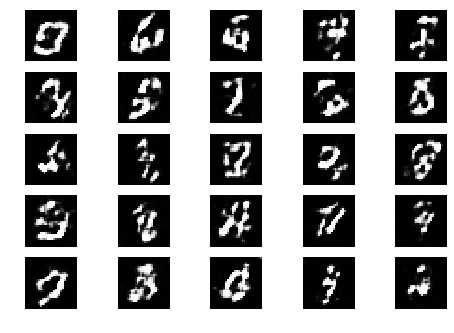

Epoch 0 Batch 851/1875 [D loss: 0.575644, acc.: 65.62%] [G loss: 1.445586]
Epoch 0 Batch 852/1875 [D loss: 0.515624, acc.: 71.88%] [G loss: 1.227841]
Epoch 0 Batch 853/1875 [D loss: 0.679895, acc.: 56.25%] [G loss: 1.209442]
Epoch 0 Batch 854/1875 [D loss: 0.899201, acc.: 40.62%] [G loss: 1.204325]
Epoch 0 Batch 855/1875 [D loss: 0.741283, acc.: 50.00%] [G loss: 1.447609]
Epoch 0 Batch 856/1875 [D loss: 0.546985, acc.: 75.00%] [G loss: 1.554750]
Epoch 0 Batch 857/1875 [D loss: 0.643940, acc.: 59.38%] [G loss: 1.565202]
Epoch 0 Batch 858/1875 [D loss: 0.688186, acc.: 56.25%] [G loss: 1.184325]
Epoch 0 Batch 859/1875 [D loss: 0.660409, acc.: 56.25%] [G loss: 0.838397]
Epoch 0 Batch 860/1875 [D loss: 0.705882, acc.: 53.12%] [G loss: 1.127133]
Epoch 0 Batch 861/1875 [D loss: 0.627747, acc.: 75.00%] [G loss: 1.212987]
Epoch 0 Batch 862/1875 [D loss: 0.696195, acc.: 62.50%] [G loss: 1.289737]
Epoch 0 Batch 863/1875 [D loss: 0.688042, acc.: 46.88%] [G loss: 1.381566]
Epoch 0 Batch 864/1875 [D

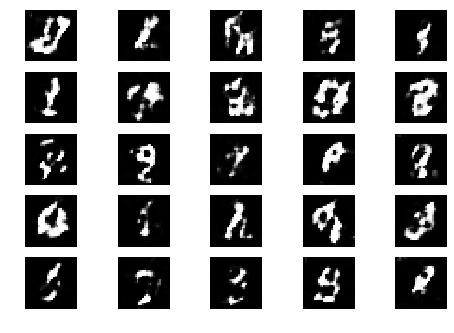

Epoch 0 Batch 901/1875 [D loss: 0.639644, acc.: 62.50%] [G loss: 0.981748]
Epoch 0 Batch 902/1875 [D loss: 0.579414, acc.: 65.62%] [G loss: 0.874899]
Epoch 0 Batch 903/1875 [D loss: 0.587870, acc.: 68.75%] [G loss: 1.162913]
Epoch 0 Batch 904/1875 [D loss: 0.558159, acc.: 75.00%] [G loss: 1.194095]
Epoch 0 Batch 905/1875 [D loss: 0.699092, acc.: 62.50%] [G loss: 1.232568]
Epoch 0 Batch 906/1875 [D loss: 0.897578, acc.: 34.38%] [G loss: 1.163624]
Epoch 0 Batch 907/1875 [D loss: 0.673102, acc.: 62.50%] [G loss: 1.401649]
Epoch 0 Batch 908/1875 [D loss: 0.786621, acc.: 50.00%] [G loss: 1.243484]
Epoch 0 Batch 909/1875 [D loss: 0.755054, acc.: 59.38%] [G loss: 1.090201]
Epoch 0 Batch 910/1875 [D loss: 0.604970, acc.: 68.75%] [G loss: 1.213619]
Epoch 0 Batch 911/1875 [D loss: 0.645488, acc.: 65.62%] [G loss: 1.208677]
Epoch 0 Batch 912/1875 [D loss: 0.551490, acc.: 68.75%] [G loss: 1.190678]
Epoch 0 Batch 913/1875 [D loss: 0.670052, acc.: 68.75%] [G loss: 1.014710]
Epoch 0 Batch 914/1875 [D

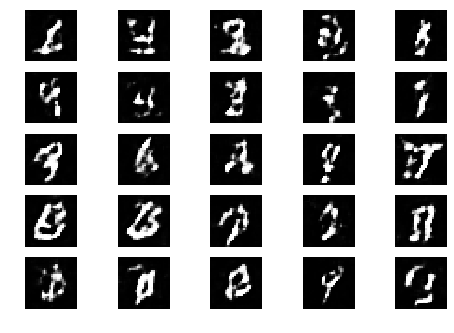

Epoch 0 Batch 951/1875 [D loss: 0.524258, acc.: 65.62%] [G loss: 1.563203]
Epoch 0 Batch 952/1875 [D loss: 0.660003, acc.: 56.25%] [G loss: 0.941766]
Epoch 0 Batch 953/1875 [D loss: 0.502336, acc.: 81.25%] [G loss: 1.174260]
Epoch 0 Batch 954/1875 [D loss: 0.542552, acc.: 75.00%] [G loss: 1.139734]
Epoch 0 Batch 955/1875 [D loss: 0.728141, acc.: 56.25%] [G loss: 1.244049]
Epoch 0 Batch 956/1875 [D loss: 0.711393, acc.: 65.62%] [G loss: 1.362421]
Epoch 0 Batch 957/1875 [D loss: 0.920246, acc.: 34.38%] [G loss: 1.174020]
Epoch 0 Batch 958/1875 [D loss: 0.983215, acc.: 40.62%] [G loss: 1.025973]
Epoch 0 Batch 959/1875 [D loss: 0.811805, acc.: 56.25%] [G loss: 1.209731]
Epoch 0 Batch 960/1875 [D loss: 0.476542, acc.: 84.38%] [G loss: 0.928312]
Epoch 0 Batch 961/1875 [D loss: 0.607621, acc.: 71.88%] [G loss: 1.183808]
Epoch 0 Batch 962/1875 [D loss: 0.688375, acc.: 62.50%] [G loss: 1.099010]
Epoch 0 Batch 963/1875 [D loss: 0.742214, acc.: 56.25%] [G loss: 1.242228]
Epoch 0 Batch 964/1875 [D

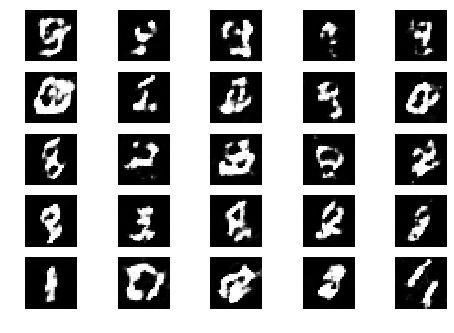

Epoch 0 Batch 1001/1875 [D loss: 0.552230, acc.: 65.62%] [G loss: 1.391809]
Epoch 0 Batch 1002/1875 [D loss: 0.932528, acc.: 31.25%] [G loss: 1.391506]
Epoch 0 Batch 1003/1875 [D loss: 0.673123, acc.: 75.00%] [G loss: 1.473334]
Epoch 0 Batch 1004/1875 [D loss: 0.542380, acc.: 78.12%] [G loss: 1.224345]
Epoch 0 Batch 1005/1875 [D loss: 0.709639, acc.: 59.38%] [G loss: 1.179033]
Epoch 0 Batch 1006/1875 [D loss: 0.534239, acc.: 65.62%] [G loss: 1.137041]
Epoch 0 Batch 1007/1875 [D loss: 0.437181, acc.: 87.50%] [G loss: 1.308618]
Epoch 0 Batch 1008/1875 [D loss: 0.827477, acc.: 50.00%] [G loss: 1.293966]
Epoch 0 Batch 1009/1875 [D loss: 0.670857, acc.: 59.38%] [G loss: 1.018400]
Epoch 0 Batch 1010/1875 [D loss: 0.679918, acc.: 62.50%] [G loss: 1.304869]
Epoch 0 Batch 1011/1875 [D loss: 0.672099, acc.: 65.62%] [G loss: 1.180067]
Epoch 0 Batch 1012/1875 [D loss: 0.533561, acc.: 68.75%] [G loss: 1.290107]
Epoch 0 Batch 1013/1875 [D loss: 0.760686, acc.: 53.12%] [G loss: 0.960031]
Epoch 0 Batc

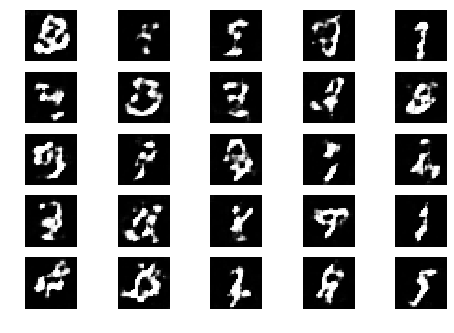

Epoch 0 Batch 1051/1875 [D loss: 0.775219, acc.: 46.88%] [G loss: 1.105530]
Epoch 0 Batch 1052/1875 [D loss: 0.420562, acc.: 90.62%] [G loss: 1.139491]
Epoch 0 Batch 1053/1875 [D loss: 0.793028, acc.: 53.12%] [G loss: 1.054955]
Epoch 0 Batch 1054/1875 [D loss: 0.586104, acc.: 68.75%] [G loss: 0.818109]
Epoch 0 Batch 1055/1875 [D loss: 0.689608, acc.: 65.62%] [G loss: 0.933398]
Epoch 0 Batch 1056/1875 [D loss: 0.593054, acc.: 75.00%] [G loss: 1.090147]
Epoch 0 Batch 1057/1875 [D loss: 0.741311, acc.: 50.00%] [G loss: 1.155445]
Epoch 0 Batch 1058/1875 [D loss: 0.721148, acc.: 46.88%] [G loss: 1.208930]
Epoch 0 Batch 1059/1875 [D loss: 0.607527, acc.: 68.75%] [G loss: 1.344980]
Epoch 0 Batch 1060/1875 [D loss: 0.833938, acc.: 56.25%] [G loss: 1.204884]
Epoch 0 Batch 1061/1875 [D loss: 0.747262, acc.: 56.25%] [G loss: 1.417155]
Epoch 0 Batch 1062/1875 [D loss: 0.766245, acc.: 59.38%] [G loss: 1.137272]
Epoch 0 Batch 1063/1875 [D loss: 0.734640, acc.: 43.75%] [G loss: 1.438484]
Epoch 0 Batc

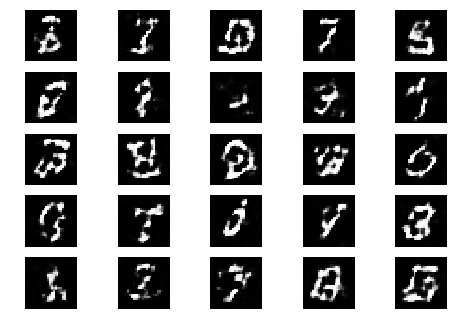

Epoch 0 Batch 1101/1875 [D loss: 0.719629, acc.: 53.12%] [G loss: 1.203524]
Epoch 0 Batch 1102/1875 [D loss: 0.702758, acc.: 53.12%] [G loss: 1.000549]
Epoch 0 Batch 1103/1875 [D loss: 0.739525, acc.: 46.88%] [G loss: 0.976793]
Epoch 0 Batch 1104/1875 [D loss: 0.650935, acc.: 65.62%] [G loss: 1.270103]
Epoch 0 Batch 1105/1875 [D loss: 0.620031, acc.: 59.38%] [G loss: 1.287654]
Epoch 0 Batch 1106/1875 [D loss: 0.661709, acc.: 65.62%] [G loss: 1.174549]
Epoch 0 Batch 1107/1875 [D loss: 0.668097, acc.: 56.25%] [G loss: 1.122662]
Epoch 0 Batch 1108/1875 [D loss: 0.607580, acc.: 65.62%] [G loss: 1.282643]
Epoch 0 Batch 1109/1875 [D loss: 0.868229, acc.: 28.12%] [G loss: 0.913859]
Epoch 0 Batch 1110/1875 [D loss: 0.767130, acc.: 53.12%] [G loss: 1.244209]
Epoch 0 Batch 1111/1875 [D loss: 0.638480, acc.: 59.38%] [G loss: 1.296901]
Epoch 0 Batch 1112/1875 [D loss: 0.683648, acc.: 62.50%] [G loss: 1.274385]
Epoch 0 Batch 1113/1875 [D loss: 0.639381, acc.: 65.62%] [G loss: 1.220127]
Epoch 0 Batc

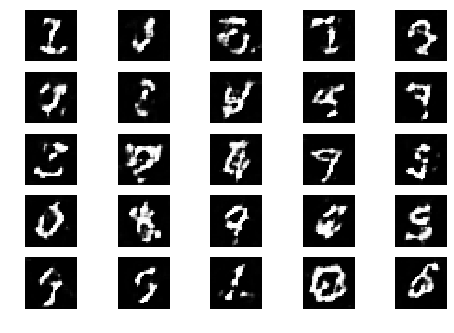

Epoch 0 Batch 1151/1875 [D loss: 0.519109, acc.: 71.88%] [G loss: 1.115111]
Epoch 0 Batch 1152/1875 [D loss: 0.688895, acc.: 53.12%] [G loss: 0.867135]
Epoch 0 Batch 1153/1875 [D loss: 0.862965, acc.: 40.62%] [G loss: 1.203817]
Epoch 0 Batch 1154/1875 [D loss: 0.641991, acc.: 62.50%] [G loss: 1.041615]
Epoch 0 Batch 1155/1875 [D loss: 0.863179, acc.: 43.75%] [G loss: 0.914227]
Epoch 0 Batch 1156/1875 [D loss: 0.648434, acc.: 56.25%] [G loss: 1.156817]
Epoch 0 Batch 1157/1875 [D loss: 0.621818, acc.: 68.75%] [G loss: 1.004595]
Epoch 0 Batch 1158/1875 [D loss: 0.715953, acc.: 62.50%] [G loss: 0.978903]
Epoch 0 Batch 1159/1875 [D loss: 0.842165, acc.: 59.38%] [G loss: 1.067496]
Epoch 0 Batch 1160/1875 [D loss: 0.582010, acc.: 62.50%] [G loss: 1.136025]
Epoch 0 Batch 1161/1875 [D loss: 0.608544, acc.: 71.88%] [G loss: 1.321649]
Epoch 0 Batch 1162/1875 [D loss: 0.658651, acc.: 65.62%] [G loss: 1.306825]
Epoch 0 Batch 1163/1875 [D loss: 0.547823, acc.: 71.88%] [G loss: 1.087978]
Epoch 0 Batc

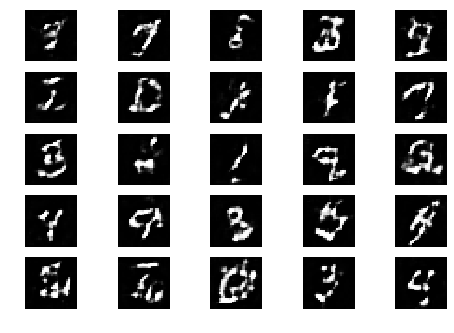

Epoch 0 Batch 1201/1875 [D loss: 0.593800, acc.: 65.62%] [G loss: 1.310479]
Epoch 0 Batch 1202/1875 [D loss: 0.815058, acc.: 46.88%] [G loss: 1.010506]
Epoch 0 Batch 1203/1875 [D loss: 0.535437, acc.: 68.75%] [G loss: 1.137141]
Epoch 0 Batch 1204/1875 [D loss: 0.628734, acc.: 59.38%] [G loss: 1.288174]
Epoch 0 Batch 1205/1875 [D loss: 0.614126, acc.: 68.75%] [G loss: 0.884919]
Epoch 0 Batch 1206/1875 [D loss: 0.676468, acc.: 59.38%] [G loss: 1.195884]
Epoch 0 Batch 1207/1875 [D loss: 0.608338, acc.: 71.88%] [G loss: 1.552628]
Epoch 0 Batch 1208/1875 [D loss: 0.826203, acc.: 53.12%] [G loss: 1.264270]
Epoch 0 Batch 1209/1875 [D loss: 0.656512, acc.: 65.62%] [G loss: 1.354543]
Epoch 0 Batch 1210/1875 [D loss: 0.644094, acc.: 50.00%] [G loss: 1.157933]
Epoch 0 Batch 1211/1875 [D loss: 0.692092, acc.: 56.25%] [G loss: 1.063425]
Epoch 0 Batch 1212/1875 [D loss: 0.522751, acc.: 75.00%] [G loss: 1.096665]
Epoch 0 Batch 1213/1875 [D loss: 0.517770, acc.: 75.00%] [G loss: 1.057920]
Epoch 0 Batc

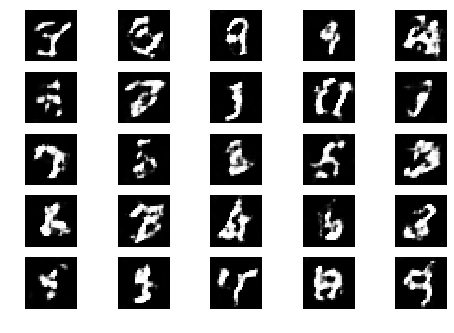

Epoch 0 Batch 1251/1875 [D loss: 0.770993, acc.: 50.00%] [G loss: 1.244650]
Epoch 0 Batch 1252/1875 [D loss: 0.850162, acc.: 50.00%] [G loss: 1.003588]
Epoch 0 Batch 1253/1875 [D loss: 0.534378, acc.: 68.75%] [G loss: 1.184882]
Epoch 0 Batch 1254/1875 [D loss: 0.785423, acc.: 56.25%] [G loss: 1.117679]
Epoch 0 Batch 1255/1875 [D loss: 0.799150, acc.: 50.00%] [G loss: 1.136013]
Epoch 0 Batch 1256/1875 [D loss: 0.807582, acc.: 56.25%] [G loss: 1.027031]
Epoch 0 Batch 1257/1875 [D loss: 0.619123, acc.: 75.00%] [G loss: 0.916331]
Epoch 0 Batch 1258/1875 [D loss: 0.862390, acc.: 40.62%] [G loss: 1.188502]
Epoch 0 Batch 1259/1875 [D loss: 0.703920, acc.: 59.38%] [G loss: 1.191454]
Epoch 0 Batch 1260/1875 [D loss: 0.571612, acc.: 65.62%] [G loss: 1.157541]
Epoch 0 Batch 1261/1875 [D loss: 0.571271, acc.: 68.75%] [G loss: 1.083000]
Epoch 0 Batch 1262/1875 [D loss: 0.634953, acc.: 56.25%] [G loss: 1.106882]
Epoch 0 Batch 1263/1875 [D loss: 0.603185, acc.: 62.50%] [G loss: 1.170842]
Epoch 0 Batc

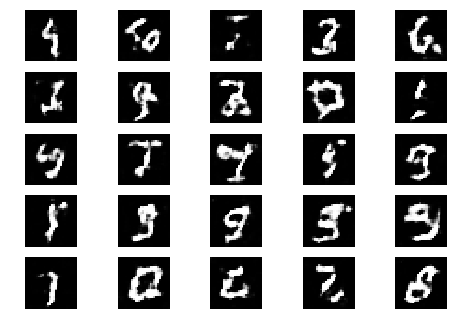

Epoch 0 Batch 1301/1875 [D loss: 0.665538, acc.: 50.00%] [G loss: 1.230828]
Epoch 0 Batch 1302/1875 [D loss: 0.621763, acc.: 68.75%] [G loss: 1.126328]
Epoch 0 Batch 1303/1875 [D loss: 0.591403, acc.: 78.12%] [G loss: 1.178165]
Epoch 0 Batch 1304/1875 [D loss: 0.595279, acc.: 62.50%] [G loss: 1.140803]
Epoch 0 Batch 1305/1875 [D loss: 0.547665, acc.: 75.00%] [G loss: 1.254070]
Epoch 0 Batch 1306/1875 [D loss: 0.789665, acc.: 59.38%] [G loss: 1.155443]
Epoch 0 Batch 1307/1875 [D loss: 0.782933, acc.: 59.38%] [G loss: 0.979891]
Epoch 0 Batch 1308/1875 [D loss: 0.642923, acc.: 59.38%] [G loss: 1.104691]
Epoch 0 Batch 1309/1875 [D loss: 0.751612, acc.: 53.12%] [G loss: 1.141679]
Epoch 0 Batch 1310/1875 [D loss: 0.664941, acc.: 65.62%] [G loss: 1.296642]
Epoch 0 Batch 1311/1875 [D loss: 0.755355, acc.: 53.12%] [G loss: 1.112379]
Epoch 0 Batch 1312/1875 [D loss: 0.483173, acc.: 78.12%] [G loss: 1.248704]
Epoch 0 Batch 1313/1875 [D loss: 0.604824, acc.: 53.12%] [G loss: 1.268554]
Epoch 0 Batc

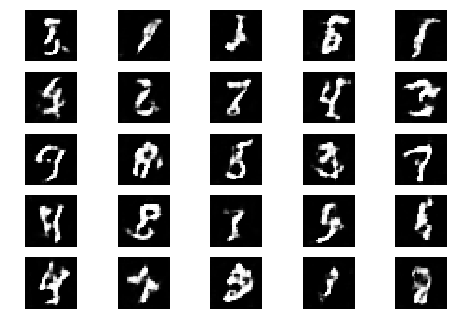

Epoch 0 Batch 1351/1875 [D loss: 0.667754, acc.: 59.38%] [G loss: 1.008443]
Epoch 0 Batch 1352/1875 [D loss: 0.608369, acc.: 68.75%] [G loss: 1.073243]
Epoch 0 Batch 1353/1875 [D loss: 0.718262, acc.: 56.25%] [G loss: 0.946990]
Epoch 0 Batch 1354/1875 [D loss: 0.512636, acc.: 84.38%] [G loss: 1.153179]
Epoch 0 Batch 1355/1875 [D loss: 0.772799, acc.: 59.38%] [G loss: 1.186007]
Epoch 0 Batch 1356/1875 [D loss: 0.644890, acc.: 65.62%] [G loss: 1.253958]
Epoch 0 Batch 1357/1875 [D loss: 0.763910, acc.: 46.88%] [G loss: 1.229332]
Epoch 0 Batch 1358/1875 [D loss: 0.733968, acc.: 50.00%] [G loss: 1.087305]
Epoch 0 Batch 1359/1875 [D loss: 0.586614, acc.: 68.75%] [G loss: 0.977977]
Epoch 0 Batch 1360/1875 [D loss: 0.863574, acc.: 40.62%] [G loss: 1.120830]
Epoch 0 Batch 1361/1875 [D loss: 0.555359, acc.: 68.75%] [G loss: 0.846483]
Epoch 0 Batch 1362/1875 [D loss: 0.483827, acc.: 78.12%] [G loss: 1.129699]
Epoch 0 Batch 1363/1875 [D loss: 0.637709, acc.: 62.50%] [G loss: 1.102792]
Epoch 0 Batc

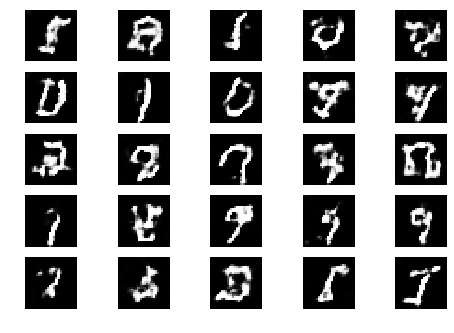

Epoch 0 Batch 1401/1875 [D loss: 0.639493, acc.: 68.75%] [G loss: 0.807837]
Epoch 0 Batch 1402/1875 [D loss: 0.643905, acc.: 53.12%] [G loss: 1.158736]
Epoch 0 Batch 1403/1875 [D loss: 0.500618, acc.: 84.38%] [G loss: 1.234416]
Epoch 0 Batch 1404/1875 [D loss: 0.640712, acc.: 62.50%] [G loss: 1.321948]
Epoch 0 Batch 1405/1875 [D loss: 0.733702, acc.: 65.62%] [G loss: 1.272068]
Epoch 0 Batch 1406/1875 [D loss: 0.644072, acc.: 62.50%] [G loss: 1.153347]
Epoch 0 Batch 1407/1875 [D loss: 0.665335, acc.: 62.50%] [G loss: 1.222916]
Epoch 0 Batch 1408/1875 [D loss: 0.803137, acc.: 53.12%] [G loss: 0.969933]
Epoch 0 Batch 1409/1875 [D loss: 0.787496, acc.: 50.00%] [G loss: 1.034472]
Epoch 0 Batch 1410/1875 [D loss: 0.647414, acc.: 62.50%] [G loss: 1.020854]
Epoch 0 Batch 1411/1875 [D loss: 0.646996, acc.: 65.62%] [G loss: 1.177871]
Epoch 0 Batch 1412/1875 [D loss: 0.770706, acc.: 56.25%] [G loss: 1.240734]
Epoch 0 Batch 1413/1875 [D loss: 0.470316, acc.: 75.00%] [G loss: 1.235006]
Epoch 0 Batc

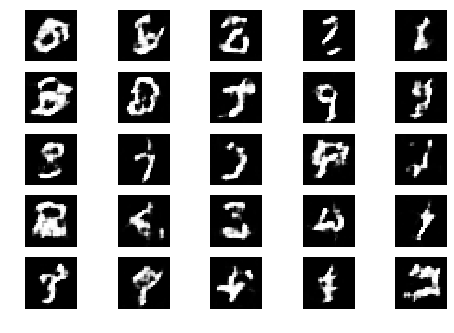

Epoch 0 Batch 1451/1875 [D loss: 0.624917, acc.: 62.50%] [G loss: 1.055182]
Epoch 0 Batch 1452/1875 [D loss: 0.537199, acc.: 65.62%] [G loss: 1.119741]
Epoch 0 Batch 1453/1875 [D loss: 0.731024, acc.: 56.25%] [G loss: 1.027549]
Epoch 0 Batch 1454/1875 [D loss: 0.668370, acc.: 53.12%] [G loss: 1.023495]
Epoch 0 Batch 1455/1875 [D loss: 0.596783, acc.: 68.75%] [G loss: 1.120735]
Epoch 0 Batch 1456/1875 [D loss: 0.536992, acc.: 78.12%] [G loss: 1.140176]
Epoch 0 Batch 1457/1875 [D loss: 0.665035, acc.: 65.62%] [G loss: 1.047585]
Epoch 0 Batch 1458/1875 [D loss: 0.756782, acc.: 62.50%] [G loss: 1.225023]
Epoch 0 Batch 1459/1875 [D loss: 0.735823, acc.: 50.00%] [G loss: 0.963751]
Epoch 0 Batch 1460/1875 [D loss: 0.727011, acc.: 59.38%] [G loss: 1.150034]
Epoch 0 Batch 1461/1875 [D loss: 0.467091, acc.: 75.00%] [G loss: 1.038338]
Epoch 0 Batch 1462/1875 [D loss: 0.726358, acc.: 59.38%] [G loss: 1.156208]
Epoch 0 Batch 1463/1875 [D loss: 0.733159, acc.: 59.38%] [G loss: 0.954543]
Epoch 0 Batc

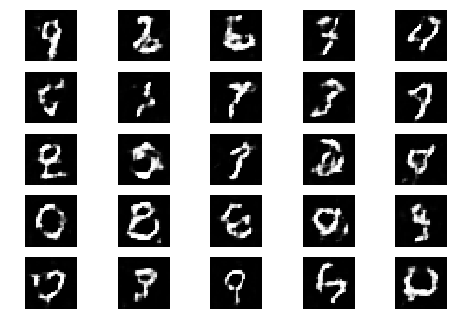

Epoch 0 Batch 1501/1875 [D loss: 0.568433, acc.: 68.75%] [G loss: 1.238211]
Epoch 0 Batch 1502/1875 [D loss: 0.678234, acc.: 59.38%] [G loss: 0.919166]
Epoch 0 Batch 1503/1875 [D loss: 0.751215, acc.: 56.25%] [G loss: 1.339719]
Epoch 0 Batch 1504/1875 [D loss: 0.672863, acc.: 59.38%] [G loss: 1.168950]
Epoch 0 Batch 1505/1875 [D loss: 0.597507, acc.: 65.62%] [G loss: 1.368723]
Epoch 0 Batch 1506/1875 [D loss: 0.717858, acc.: 46.88%] [G loss: 0.987898]
Epoch 0 Batch 1507/1875 [D loss: 0.713944, acc.: 59.38%] [G loss: 1.304403]
Epoch 0 Batch 1508/1875 [D loss: 0.521494, acc.: 71.88%] [G loss: 0.929753]
Epoch 0 Batch 1509/1875 [D loss: 0.692637, acc.: 59.38%] [G loss: 1.092131]
Epoch 0 Batch 1510/1875 [D loss: 0.631457, acc.: 65.62%] [G loss: 0.979490]
Epoch 0 Batch 1511/1875 [D loss: 0.653227, acc.: 59.38%] [G loss: 0.914745]
Epoch 0 Batch 1512/1875 [D loss: 0.661238, acc.: 50.00%] [G loss: 0.984932]
Epoch 0 Batch 1513/1875 [D loss: 0.530673, acc.: 78.12%] [G loss: 0.851860]
Epoch 0 Batc

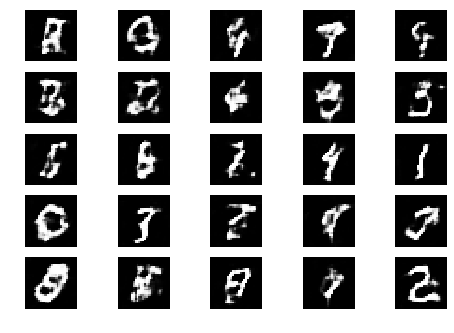

Epoch 0 Batch 1551/1875 [D loss: 0.643693, acc.: 65.62%] [G loss: 1.035675]
Epoch 0 Batch 1552/1875 [D loss: 0.736831, acc.: 50.00%] [G loss: 0.981334]
Epoch 0 Batch 1553/1875 [D loss: 0.501074, acc.: 78.12%] [G loss: 0.923024]
Epoch 0 Batch 1554/1875 [D loss: 0.642782, acc.: 65.62%] [G loss: 0.863913]
Epoch 0 Batch 1555/1875 [D loss: 0.679559, acc.: 62.50%] [G loss: 1.061721]
Epoch 0 Batch 1556/1875 [D loss: 0.751678, acc.: 59.38%] [G loss: 1.299819]
Epoch 0 Batch 1557/1875 [D loss: 0.717655, acc.: 62.50%] [G loss: 1.200676]
Epoch 0 Batch 1558/1875 [D loss: 0.724946, acc.: 56.25%] [G loss: 1.077780]
Epoch 0 Batch 1559/1875 [D loss: 0.712591, acc.: 53.12%] [G loss: 1.250531]
Epoch 0 Batch 1560/1875 [D loss: 0.692358, acc.: 65.62%] [G loss: 1.321587]
Epoch 0 Batch 1561/1875 [D loss: 0.695706, acc.: 53.12%] [G loss: 1.065257]
Epoch 0 Batch 1562/1875 [D loss: 0.737614, acc.: 53.12%] [G loss: 0.814173]
Epoch 0 Batch 1563/1875 [D loss: 0.727397, acc.: 56.25%] [G loss: 0.933284]
Epoch 0 Batc

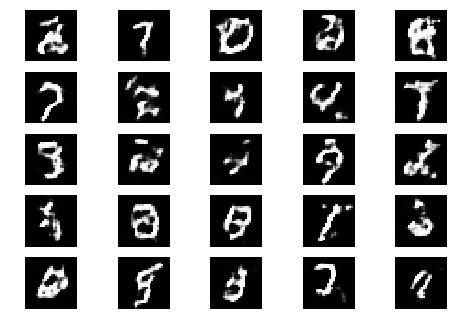

Epoch 0 Batch 1601/1875 [D loss: 0.740553, acc.: 43.75%] [G loss: 1.185832]
Epoch 0 Batch 1602/1875 [D loss: 0.634614, acc.: 56.25%] [G loss: 1.122573]
Epoch 0 Batch 1603/1875 [D loss: 0.648186, acc.: 53.12%] [G loss: 1.186564]
Epoch 0 Batch 1604/1875 [D loss: 0.711842, acc.: 62.50%] [G loss: 1.203560]
Epoch 0 Batch 1605/1875 [D loss: 0.898688, acc.: 43.75%] [G loss: 0.721170]
Epoch 0 Batch 1606/1875 [D loss: 0.637671, acc.: 65.62%] [G loss: 0.842660]
Epoch 0 Batch 1607/1875 [D loss: 0.537720, acc.: 71.88%] [G loss: 1.086696]
Epoch 0 Batch 1608/1875 [D loss: 0.440579, acc.: 84.38%] [G loss: 1.070607]
Epoch 0 Batch 1609/1875 [D loss: 0.705732, acc.: 53.12%] [G loss: 1.025121]
Epoch 0 Batch 1610/1875 [D loss: 0.624440, acc.: 62.50%] [G loss: 0.983400]
Epoch 0 Batch 1611/1875 [D loss: 0.765690, acc.: 56.25%] [G loss: 0.959652]
Epoch 0 Batch 1612/1875 [D loss: 0.521058, acc.: 81.25%] [G loss: 1.157390]
Epoch 0 Batch 1613/1875 [D loss: 0.742471, acc.: 59.38%] [G loss: 1.139169]
Epoch 0 Batc

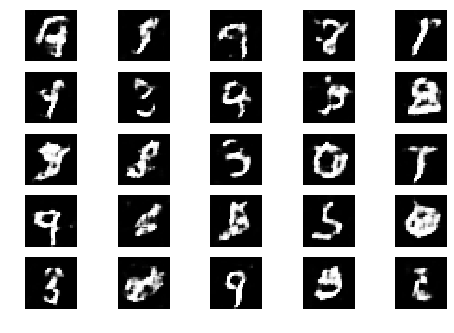

Epoch 0 Batch 1651/1875 [D loss: 0.733444, acc.: 56.25%] [G loss: 1.155234]
Epoch 0 Batch 1652/1875 [D loss: 0.739894, acc.: 56.25%] [G loss: 1.129643]
Epoch 0 Batch 1653/1875 [D loss: 0.589033, acc.: 59.38%] [G loss: 0.952606]
Epoch 0 Batch 1654/1875 [D loss: 0.464182, acc.: 87.50%] [G loss: 1.182963]
Epoch 0 Batch 1655/1875 [D loss: 0.622354, acc.: 53.12%] [G loss: 0.897756]
Epoch 0 Batch 1656/1875 [D loss: 0.623510, acc.: 59.38%] [G loss: 1.051617]
Epoch 0 Batch 1657/1875 [D loss: 0.657117, acc.: 59.38%] [G loss: 0.856899]
Epoch 0 Batch 1658/1875 [D loss: 0.623875, acc.: 62.50%] [G loss: 0.965722]
Epoch 0 Batch 1659/1875 [D loss: 0.569428, acc.: 78.12%] [G loss: 1.095019]
Epoch 0 Batch 1660/1875 [D loss: 0.581638, acc.: 56.25%] [G loss: 0.927821]
Epoch 0 Batch 1661/1875 [D loss: 0.603965, acc.: 62.50%] [G loss: 0.943616]
Epoch 0 Batch 1662/1875 [D loss: 0.790374, acc.: 53.12%] [G loss: 0.987789]
Epoch 0 Batch 1663/1875 [D loss: 0.792722, acc.: 46.88%] [G loss: 1.088118]
Epoch 0 Batc

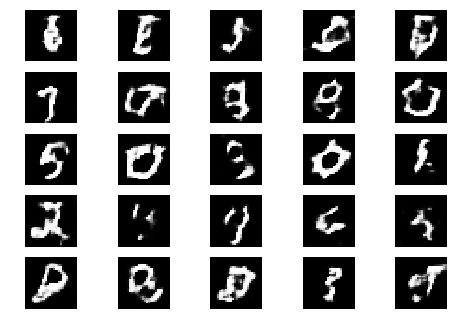

Epoch 0 Batch 1701/1875 [D loss: 0.837078, acc.: 46.88%] [G loss: 1.010414]
Epoch 0 Batch 1702/1875 [D loss: 0.836856, acc.: 50.00%] [G loss: 1.181144]
Epoch 0 Batch 1703/1875 [D loss: 0.668800, acc.: 62.50%] [G loss: 1.107792]
Epoch 0 Batch 1704/1875 [D loss: 0.701221, acc.: 56.25%] [G loss: 0.946209]
Epoch 0 Batch 1705/1875 [D loss: 0.517162, acc.: 78.12%] [G loss: 1.256023]
Epoch 0 Batch 1706/1875 [D loss: 0.644505, acc.: 56.25%] [G loss: 1.302134]
Epoch 0 Batch 1707/1875 [D loss: 0.641997, acc.: 68.75%] [G loss: 1.304833]
Epoch 0 Batch 1708/1875 [D loss: 0.588726, acc.: 62.50%] [G loss: 1.061916]
Epoch 0 Batch 1709/1875 [D loss: 0.924797, acc.: 46.88%] [G loss: 0.797016]
Epoch 0 Batch 1710/1875 [D loss: 0.585929, acc.: 71.88%] [G loss: 1.071289]
Epoch 0 Batch 1711/1875 [D loss: 0.856014, acc.: 43.75%] [G loss: 0.802676]
Epoch 0 Batch 1712/1875 [D loss: 0.690603, acc.: 62.50%] [G loss: 0.729597]
Epoch 0 Batch 1713/1875 [D loss: 0.665398, acc.: 50.00%] [G loss: 0.954646]
Epoch 0 Batc

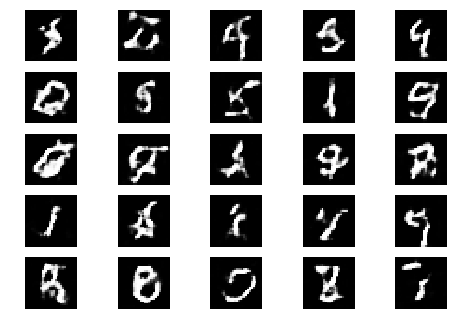

Epoch 0 Batch 1751/1875 [D loss: 0.760817, acc.: 40.62%] [G loss: 0.972254]
Epoch 0 Batch 1752/1875 [D loss: 0.719099, acc.: 56.25%] [G loss: 1.029709]
Epoch 0 Batch 1753/1875 [D loss: 0.458221, acc.: 84.38%] [G loss: 1.321251]
Epoch 0 Batch 1754/1875 [D loss: 0.751137, acc.: 59.38%] [G loss: 0.919784]
Epoch 0 Batch 1755/1875 [D loss: 0.642412, acc.: 62.50%] [G loss: 0.980350]
Epoch 0 Batch 1756/1875 [D loss: 0.623023, acc.: 71.88%] [G loss: 0.844284]
Epoch 0 Batch 1757/1875 [D loss: 0.583583, acc.: 75.00%] [G loss: 1.340465]
Epoch 0 Batch 1758/1875 [D loss: 0.641959, acc.: 59.38%] [G loss: 1.178803]
Epoch 0 Batch 1759/1875 [D loss: 0.640928, acc.: 65.62%] [G loss: 1.049603]
Epoch 0 Batch 1760/1875 [D loss: 0.723575, acc.: 53.12%] [G loss: 0.858142]
Epoch 0 Batch 1761/1875 [D loss: 0.676936, acc.: 59.38%] [G loss: 0.923855]
Epoch 0 Batch 1762/1875 [D loss: 0.678739, acc.: 56.25%] [G loss: 1.180759]
Epoch 0 Batch 1763/1875 [D loss: 0.797332, acc.: 56.25%] [G loss: 0.839538]
Epoch 0 Batc

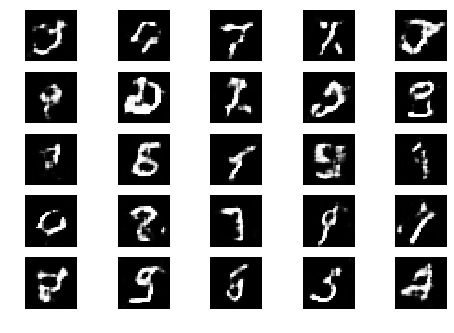

Epoch 0 Batch 1801/1875 [D loss: 0.604482, acc.: 65.62%] [G loss: 1.070718]
Epoch 0 Batch 1802/1875 [D loss: 0.688165, acc.: 56.25%] [G loss: 0.865664]
Epoch 0 Batch 1803/1875 [D loss: 0.608776, acc.: 65.62%] [G loss: 0.941183]
Epoch 0 Batch 1804/1875 [D loss: 0.672737, acc.: 62.50%] [G loss: 1.267732]
Epoch 0 Batch 1805/1875 [D loss: 0.609277, acc.: 53.12%] [G loss: 0.979187]
Epoch 0 Batch 1806/1875 [D loss: 0.638050, acc.: 62.50%] [G loss: 0.920047]
Epoch 0 Batch 1807/1875 [D loss: 0.701610, acc.: 59.38%] [G loss: 1.068855]
Epoch 0 Batch 1808/1875 [D loss: 0.555942, acc.: 71.88%] [G loss: 1.001449]
Epoch 0 Batch 1809/1875 [D loss: 0.635943, acc.: 65.62%] [G loss: 1.071720]
Epoch 0 Batch 1810/1875 [D loss: 0.675818, acc.: 59.38%] [G loss: 0.900057]
Epoch 0 Batch 1811/1875 [D loss: 0.562728, acc.: 75.00%] [G loss: 1.137882]
Epoch 0 Batch 1812/1875 [D loss: 0.552200, acc.: 68.75%] [G loss: 1.113380]
Epoch 0 Batch 1813/1875 [D loss: 0.848591, acc.: 43.75%] [G loss: 0.836238]
Epoch 0 Batc

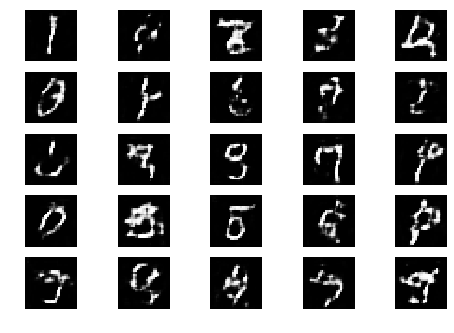

Epoch 0 Batch 1851/1875 [D loss: 0.627277, acc.: 53.12%] [G loss: 1.147345]
Epoch 0 Batch 1852/1875 [D loss: 0.693401, acc.: 53.12%] [G loss: 1.027510]
Epoch 0 Batch 1853/1875 [D loss: 0.601548, acc.: 59.38%] [G loss: 0.977086]
Epoch 0 Batch 1854/1875 [D loss: 0.499973, acc.: 78.12%] [G loss: 1.170246]
Epoch 0 Batch 1855/1875 [D loss: 0.642998, acc.: 65.62%] [G loss: 1.293858]
Epoch 0 Batch 1856/1875 [D loss: 0.581078, acc.: 81.25%] [G loss: 1.161000]
Epoch 0 Batch 1857/1875 [D loss: 0.889945, acc.: 43.75%] [G loss: 1.178772]
Epoch 0 Batch 1858/1875 [D loss: 0.608403, acc.: 59.38%] [G loss: 1.237500]
Epoch 0 Batch 1859/1875 [D loss: 0.640649, acc.: 59.38%] [G loss: 1.284606]
Epoch 0 Batch 1860/1875 [D loss: 0.740070, acc.: 53.12%] [G loss: 1.129815]
Epoch 0 Batch 1861/1875 [D loss: 0.694703, acc.: 53.12%] [G loss: 1.056577]
Epoch 0 Batch 1862/1875 [D loss: 0.785198, acc.: 56.25%] [G loss: 1.302457]
Epoch 0 Batch 1863/1875 [D loss: 0.735583, acc.: 50.00%] [G loss: 0.992765]
Epoch 0 Batc

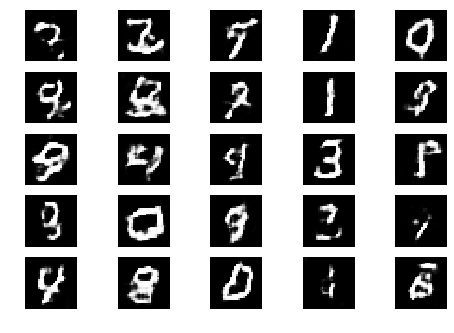

Epoch 1 Batch 1/1875 [D loss: 0.556042, acc.: 78.12%] [G loss: 0.813567]
Epoch 1 Batch 2/1875 [D loss: 0.575412, acc.: 84.38%] [G loss: 0.881685]
Epoch 1 Batch 3/1875 [D loss: 0.681845, acc.: 56.25%] [G loss: 0.886644]
Epoch 1 Batch 4/1875 [D loss: 0.710822, acc.: 56.25%] [G loss: 1.272251]
Epoch 1 Batch 5/1875 [D loss: 0.601710, acc.: 71.88%] [G loss: 1.055229]
Epoch 1 Batch 6/1875 [D loss: 0.716008, acc.: 62.50%] [G loss: 0.946046]
Epoch 1 Batch 7/1875 [D loss: 0.686077, acc.: 65.62%] [G loss: 1.152314]
Epoch 1 Batch 8/1875 [D loss: 0.636330, acc.: 59.38%] [G loss: 1.119365]
Epoch 1 Batch 9/1875 [D loss: 0.661688, acc.: 62.50%] [G loss: 1.243109]
Epoch 1 Batch 10/1875 [D loss: 0.658935, acc.: 62.50%] [G loss: 1.100103]
Epoch 1 Batch 11/1875 [D loss: 0.622182, acc.: 65.62%] [G loss: 1.039690]
Epoch 1 Batch 12/1875 [D loss: 0.724254, acc.: 56.25%] [G loss: 1.213124]
Epoch 1 Batch 13/1875 [D loss: 0.933518, acc.: 34.38%] [G loss: 0.929794]
Epoch 1 Batch 14/1875 [D loss: 0.628368, acc.: 

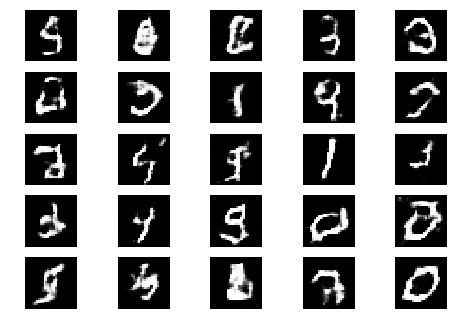

Epoch 1 Batch 51/1875 [D loss: 0.744586, acc.: 46.88%] [G loss: 1.080451]
Epoch 1 Batch 52/1875 [D loss: 0.771305, acc.: 53.12%] [G loss: 1.371821]
Epoch 1 Batch 53/1875 [D loss: 0.734870, acc.: 56.25%] [G loss: 1.128156]
Epoch 1 Batch 54/1875 [D loss: 0.762121, acc.: 53.12%] [G loss: 1.085503]
Epoch 1 Batch 55/1875 [D loss: 0.832556, acc.: 43.75%] [G loss: 1.069855]
Epoch 1 Batch 56/1875 [D loss: 0.641504, acc.: 59.38%] [G loss: 1.149480]
Epoch 1 Batch 57/1875 [D loss: 0.615201, acc.: 65.62%] [G loss: 1.059492]
Epoch 1 Batch 58/1875 [D loss: 0.616179, acc.: 65.62%] [G loss: 1.145869]
Epoch 1 Batch 59/1875 [D loss: 0.596440, acc.: 71.88%] [G loss: 0.817172]
Epoch 1 Batch 60/1875 [D loss: 0.726864, acc.: 46.88%] [G loss: 0.928982]
Epoch 1 Batch 61/1875 [D loss: 0.721660, acc.: 53.12%] [G loss: 0.956689]
Epoch 1 Batch 62/1875 [D loss: 0.781957, acc.: 43.75%] [G loss: 1.196152]
Epoch 1 Batch 63/1875 [D loss: 0.542489, acc.: 68.75%] [G loss: 1.049559]
Epoch 1 Batch 64/1875 [D loss: 0.63037

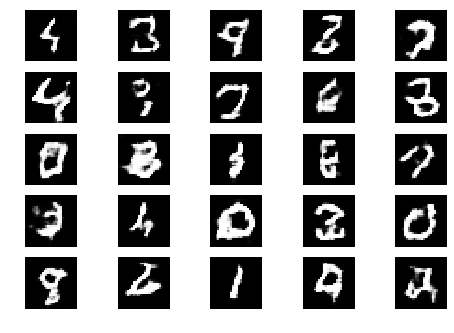

Epoch 1 Batch 101/1875 [D loss: 0.690599, acc.: 59.38%] [G loss: 1.153427]
Epoch 1 Batch 102/1875 [D loss: 0.818643, acc.: 50.00%] [G loss: 0.939743]
Epoch 1 Batch 103/1875 [D loss: 0.696452, acc.: 68.75%] [G loss: 1.219962]
Epoch 1 Batch 104/1875 [D loss: 0.610072, acc.: 59.38%] [G loss: 1.302708]
Epoch 1 Batch 105/1875 [D loss: 0.620481, acc.: 62.50%] [G loss: 0.933382]
Epoch 1 Batch 106/1875 [D loss: 0.716107, acc.: 62.50%] [G loss: 1.083371]
Epoch 1 Batch 107/1875 [D loss: 0.705270, acc.: 62.50%] [G loss: 0.929737]
Epoch 1 Batch 108/1875 [D loss: 0.797094, acc.: 59.38%] [G loss: 0.969974]
Epoch 1 Batch 109/1875 [D loss: 0.554237, acc.: 78.12%] [G loss: 1.089890]
Epoch 1 Batch 110/1875 [D loss: 0.563316, acc.: 62.50%] [G loss: 0.981337]
Epoch 1 Batch 111/1875 [D loss: 0.685600, acc.: 59.38%] [G loss: 0.937983]
Epoch 1 Batch 112/1875 [D loss: 0.739926, acc.: 56.25%] [G loss: 1.187920]
Epoch 1 Batch 113/1875 [D loss: 0.765997, acc.: 65.62%] [G loss: 1.085285]
Epoch 1 Batch 114/1875 [D

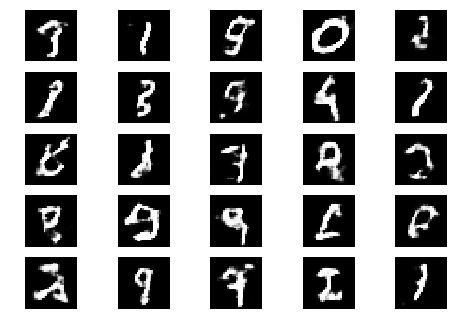

Epoch 1 Batch 151/1875 [D loss: 0.661865, acc.: 59.38%] [G loss: 1.033070]
Epoch 1 Batch 152/1875 [D loss: 0.871979, acc.: 40.62%] [G loss: 0.865919]
Epoch 1 Batch 153/1875 [D loss: 0.746640, acc.: 53.12%] [G loss: 1.036912]
Epoch 1 Batch 154/1875 [D loss: 0.655870, acc.: 71.88%] [G loss: 1.108142]
Epoch 1 Batch 155/1875 [D loss: 0.736678, acc.: 56.25%] [G loss: 0.859444]
Epoch 1 Batch 156/1875 [D loss: 0.572095, acc.: 68.75%] [G loss: 0.942407]
Epoch 1 Batch 157/1875 [D loss: 0.574096, acc.: 68.75%] [G loss: 0.850467]
Epoch 1 Batch 158/1875 [D loss: 0.601958, acc.: 65.62%] [G loss: 0.917988]
Epoch 1 Batch 159/1875 [D loss: 0.810397, acc.: 37.50%] [G loss: 0.907010]
Epoch 1 Batch 160/1875 [D loss: 0.699786, acc.: 62.50%] [G loss: 1.196069]
Epoch 1 Batch 161/1875 [D loss: 0.424967, acc.: 84.38%] [G loss: 0.983811]
Epoch 1 Batch 162/1875 [D loss: 0.707222, acc.: 59.38%] [G loss: 1.048504]
Epoch 1 Batch 163/1875 [D loss: 0.540861, acc.: 78.12%] [G loss: 1.045947]
Epoch 1 Batch 164/1875 [D

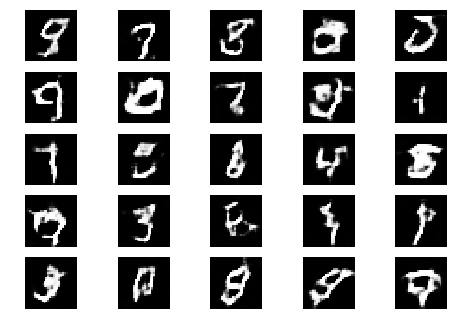

Epoch 1 Batch 201/1875 [D loss: 0.691763, acc.: 62.50%] [G loss: 1.096443]
Epoch 1 Batch 202/1875 [D loss: 0.565532, acc.: 68.75%] [G loss: 1.046255]
Epoch 1 Batch 203/1875 [D loss: 0.644738, acc.: 62.50%] [G loss: 0.910585]
Epoch 1 Batch 204/1875 [D loss: 0.750874, acc.: 59.38%] [G loss: 1.182589]
Epoch 1 Batch 205/1875 [D loss: 0.611688, acc.: 78.12%] [G loss: 1.115510]
Epoch 1 Batch 206/1875 [D loss: 0.788545, acc.: 50.00%] [G loss: 1.085778]
Epoch 1 Batch 207/1875 [D loss: 0.642186, acc.: 56.25%] [G loss: 1.056072]
Epoch 1 Batch 208/1875 [D loss: 0.603506, acc.: 75.00%] [G loss: 1.271213]
Epoch 1 Batch 209/1875 [D loss: 0.647275, acc.: 65.62%] [G loss: 1.013139]
Epoch 1 Batch 210/1875 [D loss: 0.631698, acc.: 59.38%] [G loss: 1.175793]
Epoch 1 Batch 211/1875 [D loss: 0.637170, acc.: 62.50%] [G loss: 1.107793]
Epoch 1 Batch 212/1875 [D loss: 0.671492, acc.: 59.38%] [G loss: 1.240655]
Epoch 1 Batch 213/1875 [D loss: 0.697368, acc.: 62.50%] [G loss: 0.959533]
Epoch 1 Batch 214/1875 [D

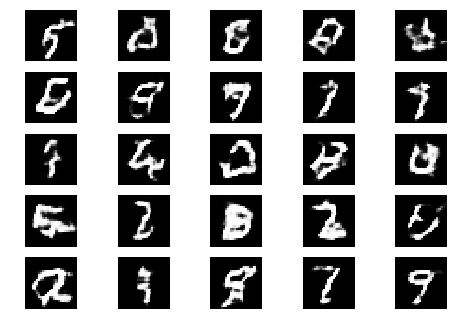

Epoch 1 Batch 251/1875 [D loss: 0.527531, acc.: 71.88%] [G loss: 1.102887]
Epoch 1 Batch 252/1875 [D loss: 0.678044, acc.: 56.25%] [G loss: 1.055253]
Epoch 1 Batch 253/1875 [D loss: 0.740148, acc.: 56.25%] [G loss: 1.066025]
Epoch 1 Batch 254/1875 [D loss: 0.814655, acc.: 46.88%] [G loss: 1.181857]
Epoch 1 Batch 255/1875 [D loss: 0.554834, acc.: 62.50%] [G loss: 1.239919]
Epoch 1 Batch 256/1875 [D loss: 0.728093, acc.: 53.12%] [G loss: 1.074013]
Epoch 1 Batch 257/1875 [D loss: 0.602577, acc.: 71.88%] [G loss: 0.806916]
Epoch 1 Batch 258/1875 [D loss: 0.589477, acc.: 65.62%] [G loss: 1.000458]
Epoch 1 Batch 259/1875 [D loss: 0.643702, acc.: 59.38%] [G loss: 1.094692]
Epoch 1 Batch 260/1875 [D loss: 0.614557, acc.: 65.62%] [G loss: 1.076666]
Epoch 1 Batch 261/1875 [D loss: 0.783448, acc.: 40.62%] [G loss: 1.011538]
Epoch 1 Batch 262/1875 [D loss: 0.706222, acc.: 56.25%] [G loss: 1.246192]
Epoch 1 Batch 263/1875 [D loss: 0.672925, acc.: 65.62%] [G loss: 1.082254]
Epoch 1 Batch 264/1875 [D

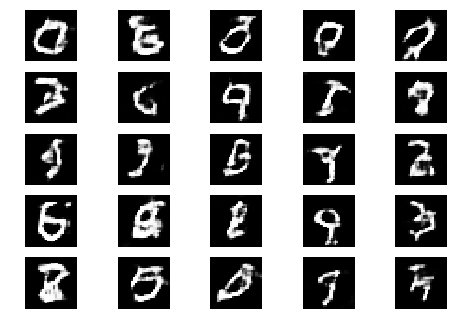

Epoch 1 Batch 301/1875 [D loss: 0.642965, acc.: 68.75%] [G loss: 1.089171]
Epoch 1 Batch 302/1875 [D loss: 0.508861, acc.: 84.38%] [G loss: 1.271428]
Epoch 1 Batch 303/1875 [D loss: 0.671519, acc.: 53.12%] [G loss: 1.246120]
Epoch 1 Batch 304/1875 [D loss: 0.551051, acc.: 68.75%] [G loss: 1.121821]
Epoch 1 Batch 305/1875 [D loss: 0.641989, acc.: 65.62%] [G loss: 0.991039]
Epoch 1 Batch 306/1875 [D loss: 0.695840, acc.: 56.25%] [G loss: 0.886778]
Epoch 1 Batch 307/1875 [D loss: 0.756531, acc.: 43.75%] [G loss: 0.968121]
Epoch 1 Batch 308/1875 [D loss: 0.647274, acc.: 56.25%] [G loss: 1.095270]
Epoch 1 Batch 309/1875 [D loss: 0.672006, acc.: 56.25%] [G loss: 1.227829]
Epoch 1 Batch 310/1875 [D loss: 0.613978, acc.: 71.88%] [G loss: 1.069021]
Epoch 1 Batch 311/1875 [D loss: 0.648864, acc.: 62.50%] [G loss: 0.975259]
Epoch 1 Batch 312/1875 [D loss: 0.709757, acc.: 62.50%] [G loss: 0.902269]
Epoch 1 Batch 313/1875 [D loss: 0.807865, acc.: 50.00%] [G loss: 1.018167]
Epoch 1 Batch 314/1875 [D

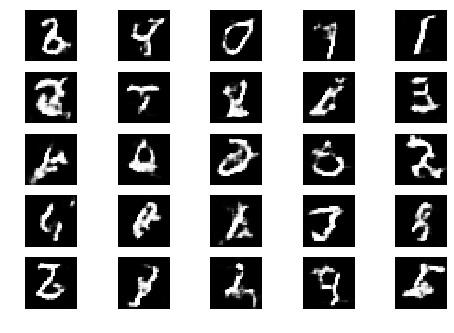

Epoch 1 Batch 351/1875 [D loss: 0.505902, acc.: 78.12%] [G loss: 1.149290]
Epoch 1 Batch 352/1875 [D loss: 0.785011, acc.: 53.12%] [G loss: 1.028921]
Epoch 1 Batch 353/1875 [D loss: 0.720942, acc.: 50.00%] [G loss: 0.976449]
Epoch 1 Batch 354/1875 [D loss: 0.634023, acc.: 56.25%] [G loss: 0.790845]
Epoch 1 Batch 355/1875 [D loss: 0.609262, acc.: 59.38%] [G loss: 0.989473]
Epoch 1 Batch 356/1875 [D loss: 0.624695, acc.: 65.62%] [G loss: 1.049977]
Epoch 1 Batch 357/1875 [D loss: 0.616371, acc.: 65.62%] [G loss: 1.020079]
Epoch 1 Batch 358/1875 [D loss: 0.515975, acc.: 87.50%] [G loss: 0.980839]
Epoch 1 Batch 359/1875 [D loss: 0.798862, acc.: 53.12%] [G loss: 1.002560]
Epoch 1 Batch 360/1875 [D loss: 0.528958, acc.: 71.88%] [G loss: 1.189899]
Epoch 1 Batch 361/1875 [D loss: 0.669990, acc.: 56.25%] [G loss: 0.797272]
Epoch 1 Batch 362/1875 [D loss: 0.593676, acc.: 65.62%] [G loss: 0.919935]
Epoch 1 Batch 363/1875 [D loss: 0.631879, acc.: 62.50%] [G loss: 0.900257]
Epoch 1 Batch 364/1875 [D

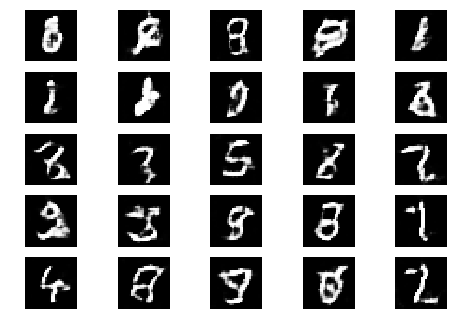

Epoch 1 Batch 401/1875 [D loss: 0.623271, acc.: 56.25%] [G loss: 0.889015]
Epoch 1 Batch 402/1875 [D loss: 0.563332, acc.: 75.00%] [G loss: 0.925454]
Epoch 1 Batch 403/1875 [D loss: 0.642230, acc.: 71.88%] [G loss: 1.001995]
Epoch 1 Batch 404/1875 [D loss: 0.565371, acc.: 65.62%] [G loss: 1.118524]
Epoch 1 Batch 405/1875 [D loss: 0.561861, acc.: 68.75%] [G loss: 1.105735]
Epoch 1 Batch 406/1875 [D loss: 0.564593, acc.: 68.75%] [G loss: 1.142550]
Epoch 1 Batch 407/1875 [D loss: 0.652118, acc.: 68.75%] [G loss: 1.110634]
Epoch 1 Batch 408/1875 [D loss: 0.812590, acc.: 50.00%] [G loss: 0.963048]
Epoch 1 Batch 409/1875 [D loss: 0.668325, acc.: 59.38%] [G loss: 1.060952]
Epoch 1 Batch 410/1875 [D loss: 0.582250, acc.: 75.00%] [G loss: 0.936283]
Epoch 1 Batch 411/1875 [D loss: 0.733866, acc.: 65.62%] [G loss: 1.108336]
Epoch 1 Batch 412/1875 [D loss: 0.528025, acc.: 78.12%] [G loss: 0.900571]
Epoch 1 Batch 413/1875 [D loss: 0.481924, acc.: 78.12%] [G loss: 1.023722]
Epoch 1 Batch 414/1875 [D

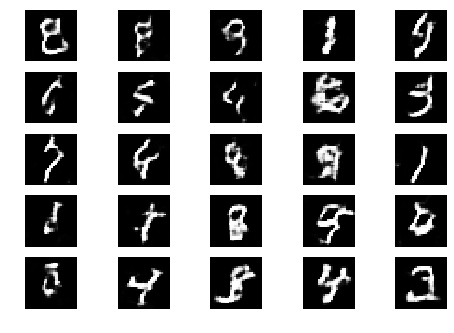

Epoch 1 Batch 451/1875 [D loss: 0.682990, acc.: 62.50%] [G loss: 0.996950]
Epoch 1 Batch 452/1875 [D loss: 0.591768, acc.: 62.50%] [G loss: 1.047405]
Epoch 1 Batch 453/1875 [D loss: 0.646525, acc.: 59.38%] [G loss: 1.091770]
Epoch 1 Batch 454/1875 [D loss: 0.617897, acc.: 75.00%] [G loss: 1.218793]
Epoch 1 Batch 455/1875 [D loss: 0.673809, acc.: 59.38%] [G loss: 1.074960]
Epoch 1 Batch 456/1875 [D loss: 0.568308, acc.: 75.00%] [G loss: 0.906433]
Epoch 1 Batch 457/1875 [D loss: 0.711468, acc.: 56.25%] [G loss: 0.984958]
Epoch 1 Batch 458/1875 [D loss: 0.790247, acc.: 53.12%] [G loss: 1.057058]
Epoch 1 Batch 459/1875 [D loss: 0.559987, acc.: 68.75%] [G loss: 1.129378]
Epoch 1 Batch 460/1875 [D loss: 0.733025, acc.: 53.12%] [G loss: 1.094947]
Epoch 1 Batch 461/1875 [D loss: 0.607083, acc.: 75.00%] [G loss: 0.907839]
Epoch 1 Batch 462/1875 [D loss: 0.698166, acc.: 62.50%] [G loss: 0.978364]
Epoch 1 Batch 463/1875 [D loss: 0.613517, acc.: 71.88%] [G loss: 1.026436]
Epoch 1 Batch 464/1875 [D

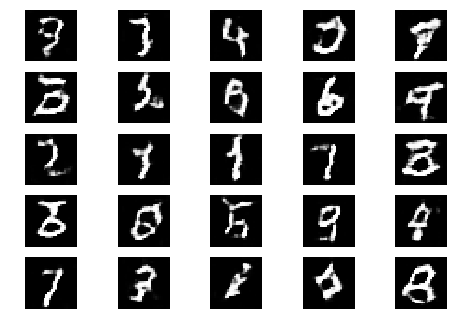

In [0]:
if __name__ == '__main__':
    main()

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)